In [481]:
import os
import sys
import importlib
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm

import Data_Sourcing_v1
importlib.reload(Data_Sourcing_v1)
from Data_Sourcing_v1 import download_data

import Data_Sourcing_DBnomics_v1
importlib.reload(Data_Sourcing_DBnomics_v1)
from Data_Sourcing_DBnomics_v1 import dbnomics_download

import Data_Sourcing_Yfinance_v1
importlib.reload(Data_Sourcing_Yfinance_v1)
from Data_Sourcing_Yfinance_v1 import download_data_yfinance

kkr_purple = '#590e5b'
marker_color = '#FF69B4'

In [482]:
print(os.getcwd())
print(sys.executable)

c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle
C:\Users\jerem\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe


In [483]:
def download_data_yfinance(ticker, start_date, end_date):

    sp500_data = yf.download(ticker, start=start_date, end=end_date)
    closing_prices = sp500_data['Close']
    monthly_closing_prices = closing_prices.resample('M').mean()
    return closing_prices, monthly_closing_prices

In [484]:
def graph(series,title_1, label_1, y_label_1, title_2, label_2, y_label_2):

    fig, axs = plt.subplots(2,1, figsize = (10,6))

    kkr_purple = '#590e5b'  # Approximate hex color from the KKR logo
    marker_color = '#FF69B4'  # Another shade for the markers (pink)

    # First subplot: Full year-over-year percentage change
    axs[0].plot(series, color=kkr_purple, label= label_1, linewidth = 0.7)
    axs[0].set_title(title_1)
    axs[0].set_ylabel(y_label_1)
    axs[0].legend(loc="upper left")  # Add legend here with label
    axs[0].grid(True)
    # Second subplot: Last 12 months with mean line and markers
    axs[1].plot(series.iloc[-12:], color=kkr_purple, label= label_2, linewidth = 0.7)
    axs[1].scatter(series.iloc[-12:].index, series.iloc[-12:], color=marker_color, label="Monthly Data")
    axs[1].axhline(series.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
    axs[1].set_title(title_2)
    axs[1].set_ylabel(y_label_2)
    axs[1].set_xlabel("Date")
    axs[1].legend(loc="upper left")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show

In [485]:
# download ISM data from
df1, df2 = dbnomics_download()
ISM = pd.DataFrame()
ISM['manufacturing'] = df1['value']
ISM['non manufacturing'] =df2['value']
ISM = ISM.set_index(df1['period'])

ISM['Manufacturing delta neutral'] = (50 - ISM['manufacturing'])/ 50
ISM['Non manufacturing delta neutral'] = (50 - ISM['non manufacturing'])/50

#adjust the dates in the index to reflect eom
ISM.index = ISM.index - pd.offsets.MonthEnd(1)

new_row_date = ISM.index.max() + pd.DateOffset(months=1)
ISM.loc[new_row_date] = [np.nan] * ISM.shape[1]
ISM =  ISM.shift(1)

  @frequency provider_code dataset_code         dataset_name series_code  \
0    monthly           ISM          pmi  Manufacturing - PMI          pm   
1    monthly           ISM          pmi  Manufacturing - PMI          pm   
2    monthly           ISM          pmi  Manufacturing - PMI          pm   
3    monthly           ISM          pmi  Manufacturing - PMI          pm   
4    monthly           ISM          pmi  Manufacturing - PMI          pm   

  series_name original_period     period  original_value  value frequency  \
0         PMI         2020-05 2020-05-01            43.1   43.1         M   
1         PMI         2020-06 2020-06-01            52.2   52.2         M   
2         PMI         2020-07 2020-07-01            53.7   53.7         M   
3         PMI         2020-08 2020-08-01            55.6   55.6         M   
4         PMI         2020-09 2020-09-01            55.7   55.7         M   

  Frequency  
0   Monthly  
1   Monthly  
2   Monthly  
3   Monthly  
4   Monthl

In [486]:
# define the tickers necessary for the dashboards

Markets = ['SP500', 'GS10','TB3MS', 'DBAA', 'DAAA','BAMLH0A0HYM2','DCOILWTICO']
stock_market = ['SP500']



end_date = date.today() - timedelta(days = 1)
start_date = end_date - relativedelta(years = 50)
#print(f'data begins at {start_date} and ends at date {end_date}')




In [487]:
# download SP500 data using yfinance
stock_market = "^GSPC"

(stock_market_data,
  stock_market_data_averages) = download_data_yfinance(stock_market, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3004855266.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_closing_prices = closing_prices.resample('M').mean()


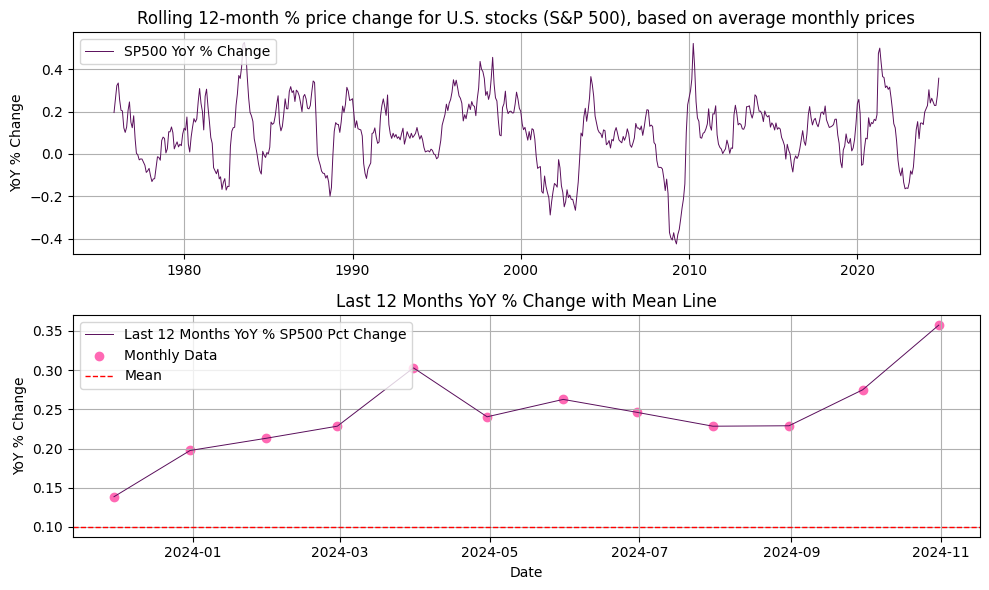

In [488]:
# focus on the Market data
year_delta_stock_market = stock_market_data_averages.pct_change(12)

graph(year_delta_stock_market,
      "Rolling 12-month % price change for U.S. stocks (S&P 500), based on average monthly prices",
      "SP500 YoY % Change",
      "YoY % Change",
      "Last 12 Months YoY % Change with Mean Line",
      "Last 12 Months YoY % SP500 Pct Change",
      "YoY % Change"
      )

FREQUENCY OF TICKER:
T10Y3M : Daily


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
GS10 : Monthly
FREQUENCY OF TICKER:
TB3MS : Monthly


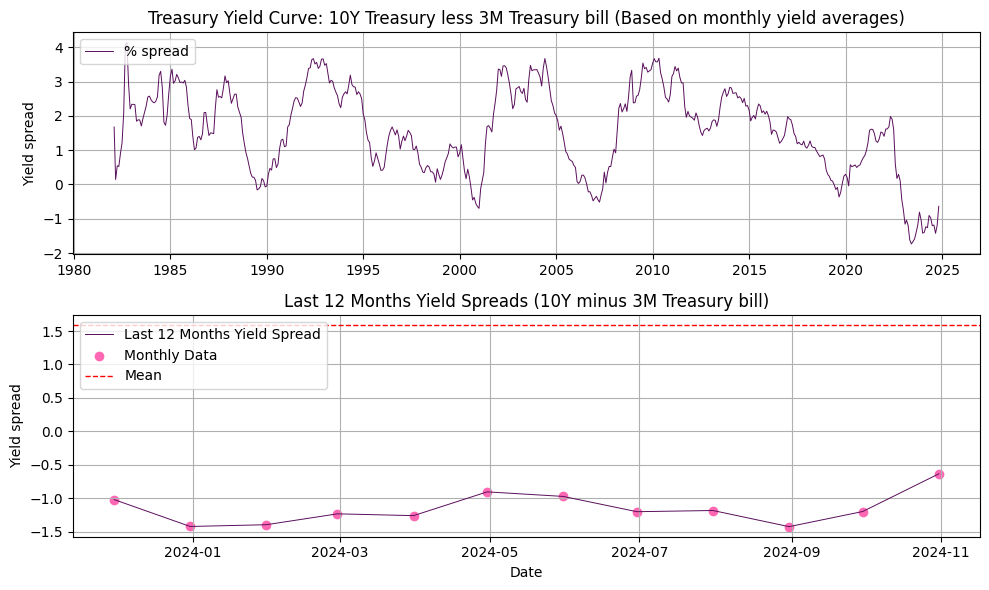

In [489]:
# Yield Spread analysis using T10Y3M provided by the FED database
'''
Utilize the spread between 10-Year and 3-month Treasury Constant Maturities, which is used to predict recession probabilities
'''

yield_curve = ['T10Y3M','GS10','TB3MS']

(yield_curve_data,
  yield_curve_data_averages) = download_data(yield_curve, start_date, end_date)

graph(yield_curve_data_averages['T10Y3M'],
      "Treasury Yield Curve: 10Y Treasury less 3M Treasury bill (Based on monthly yield averages)",
      "% spread",
      "Yield spread",
      "Last 12 Months Yield Spreads (10Y minus 3M Treasury bill)",
      "Last 12 Months Yield Spread",
      "Yield spread",
      )

FREQUENCY OF TICKER:
DBAA : Daily


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
DAAA : Daily
FREQUENCY OF TICKER:
BAMLH0A0HYM2EY : Daily, Close


C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\2892889553.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_Baa_Aaa_spread = Baa_Aaa_spread.resample('M').mean()
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\2892889553.py:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_HY_spread = HY_Aaa_spread.resample('M').mean()


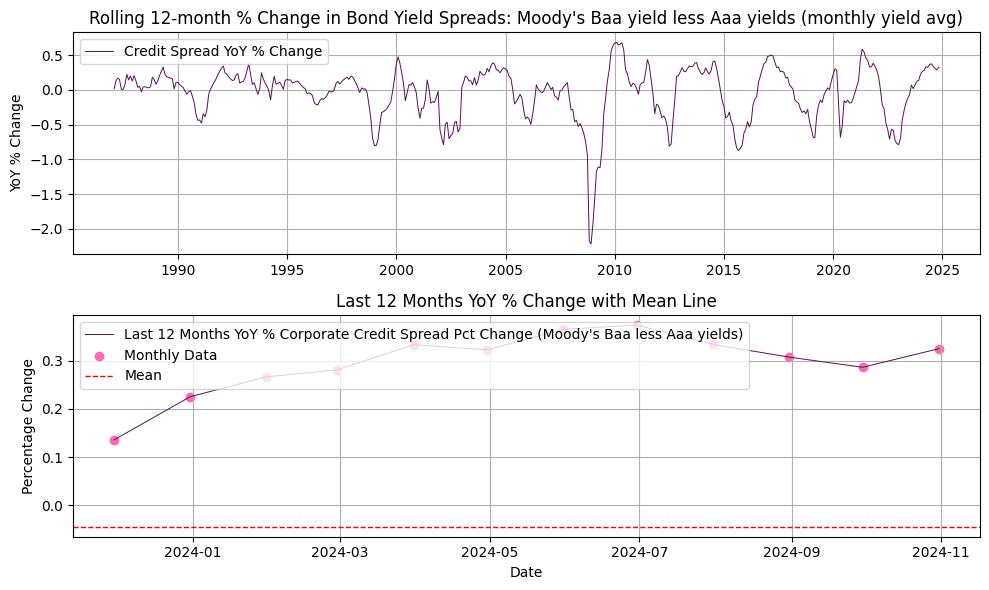

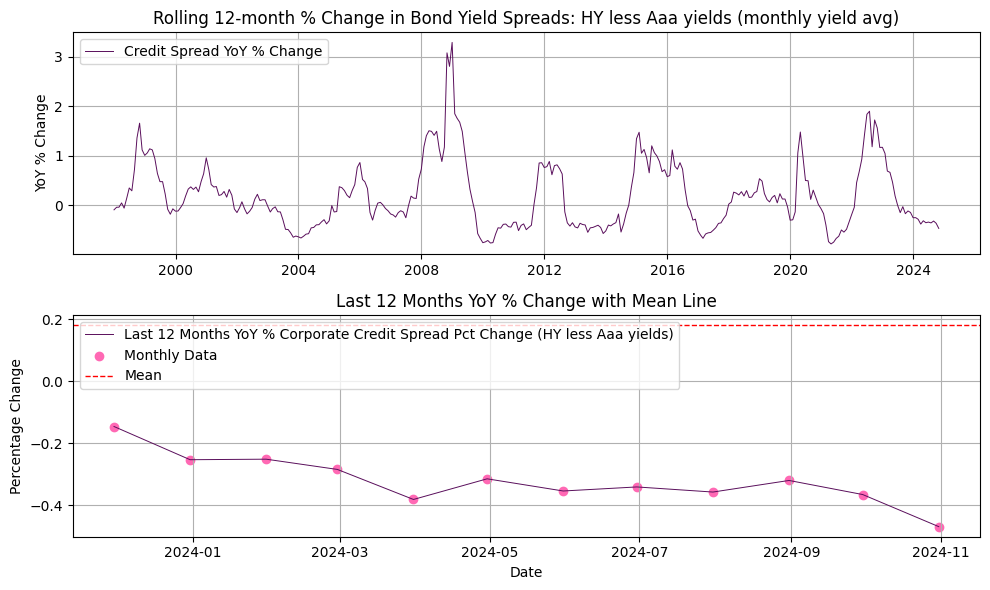

In [490]:
# Credit Spreads

credit_spreads = ['DBAA', 'DAAA','BAMLH0A0HYM2EY']


(credit_spread_data,
  credit_spread_data_averages) = download_data(credit_spreads, start_date, end_date)

# First we use the AAA - BAA spread

Baa_Aaa_spread = credit_spread_data['DBAA'] - credit_spread_data['DAAA']
avg_Baa_Aaa_spread = Baa_Aaa_spread.resample('M').mean()
year_delta_credit_spread =  -1 *avg_Baa_Aaa_spread.pct_change(12) # we multiply by -1 since an increase in credit spread is negative
year_delta_credit_spread.dropna(inplace = True)
year_delta_credit_spread.name = 'Credit spread'


graph(year_delta_credit_spread,
      "Rolling 12-month % Change in Bond Yield Spreads: Moody's Baa yield less Aaa yields (monthly yield avg)",
      "Credit Spread YoY % Change",
      "YoY % Change",
      "Last 12 Months YoY % Change with Mean Line",
      "Last 12 Months YoY % Corporate Credit Spread Pct Change (Moody's Baa less Aaa yields)",
      "Percentage Change",
      )

# Using BoFa Meryl Lynch junk bond spread data

HY_Aaa_spread = credit_spread_data['BAMLH0A0HYM2EY'] - credit_spread_data['DAAA']
HY_Aaa_spread.dropna(inplace = True)
avg_HY_spread = HY_Aaa_spread.resample('M').mean()
year_delta_HY_spread = avg_HY_spread.pct_change(12)


graph(year_delta_HY_spread,
      "Rolling 12-month % Change in Bond Yield Spreads: HY less Aaa yields (monthly yield avg)",
      "Credit Spread YoY % Change",
      "YoY % Change",
      "Last 12 Months YoY % Change with Mean Line",
      "Last 12 Months YoY % Corporate Credit Spread Pct Change (HY less Aaa yields)",
      "Percentage Change",
      )




FREQUENCY OF TICKER:
USPRIV : Monthly
FREQUENCY OF TICKER:
ICSA : Weekly, Ending Saturday


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


FREQUENCY OF TICKER:
UNEMPLOY : Monthly
FREQUENCY OF TICKER:
CE16OV : Monthly
FREQUENCY OF TICKER:
AWHI : Monthly


C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\538984932.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  labour_market_data_averages['employment_ratio'] = labour_market_data['employment_ratio'].resample('M').mean()
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\538984932.py:17: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  year_delta_labour_market = labour_market_data_averages.pct_change(12)


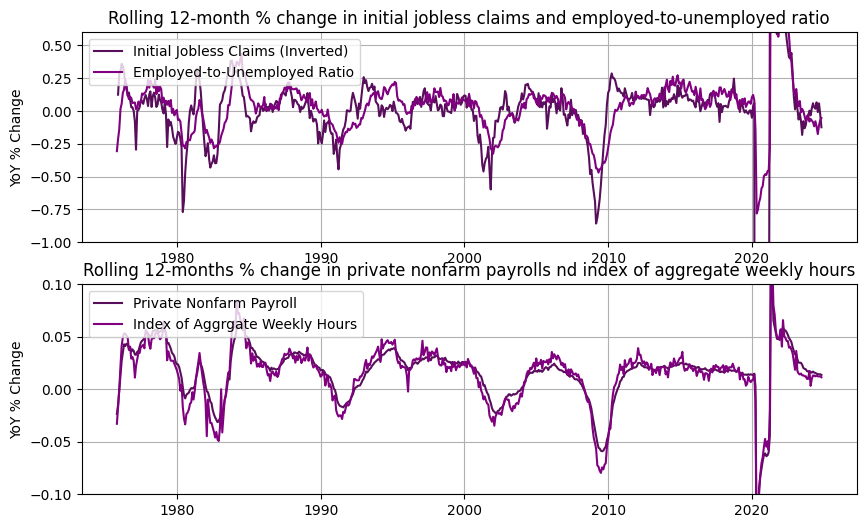

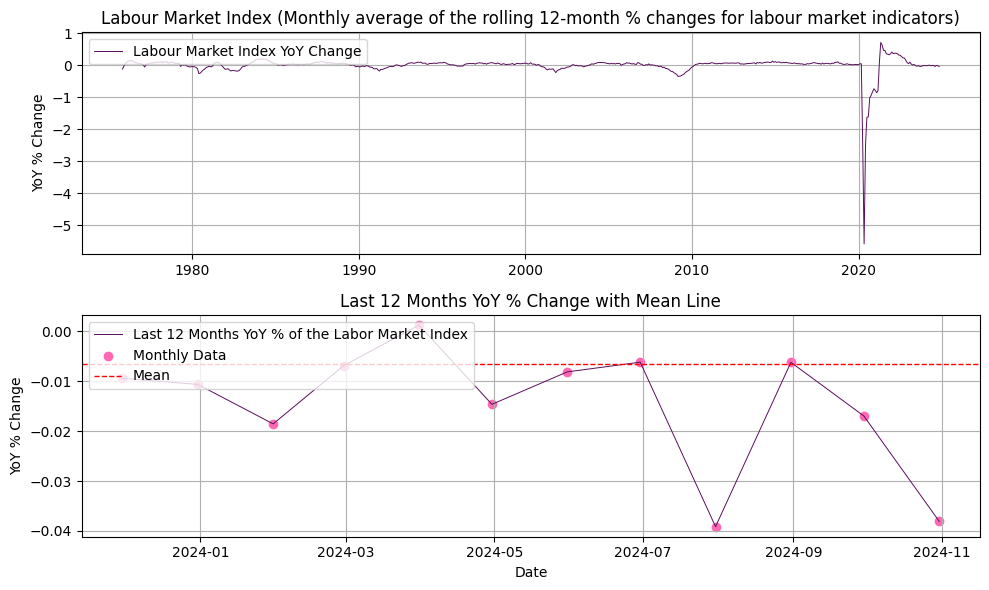

In [491]:
# labour market

labour_market = ['USPRIV','ICSA','UNEMPLOY', 'CE16OV', 'AWHI']

(labour_market_data,
  labour_market_data_averages) = download_data(labour_market, start_date, end_date)



# build the labour market index
labour_market_data['employment_ratio'] = labour_market_data['CE16OV'] / labour_market_data['UNEMPLOY']
labour_market_data_averages['employment_ratio'] = labour_market_data['employment_ratio'].resample('M').mean() 

#Need to tadjust for the FRED's way of indexing time series data
labour_market_data_averages[['USPRIV','UNEMPLOY','CE16OV','AWHI', 'employment_ratio']] = labour_market_data_averages[['USPRIV','UNEMPLOY','CE16OV','AWHI', 'employment_ratio']].shift(1)

year_delta_labour_market = labour_market_data_averages.pct_change(12)
year_delta_labour_market['ICSA'] = year_delta_labour_market['ICSA'] * -1 

labour_market_index = year_delta_labour_market[['ICSA', 'employment_ratio', 'USPRIV', 'AWHI']].mean(axis = 1)
labour_market_index.name = 'labour_market_index'

# plot the constituents of the Labour market index

fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_labour_market['ICSA'], color=kkr_purple, label="Initial Jobless Claims (Inverted)")
axs[0].plot(year_delta_labour_market['employment_ratio'], color= 'purple', label="Employed-to-Unemployed Ratio")
axs[0].set_title("Rolling 12-month % change in initial jobless claims and employed-to-unemployed ratio")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
axs[0].set_ylim(-1, 0.6)

axs[1].plot(year_delta_labour_market['USPRIV'], color=kkr_purple, label="Private Nonfarm Payroll")
axs[1].plot(year_delta_labour_market['AWHI'], color='purple', label="Index of Aggrgate Weekly Hours")
axs[1].set_title("Rolling 12-months % change in private nonfarm payrolls nd index of aggregate weekly hours")
axs[1].set_ylabel("YoY % Change")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)
axs[1].set_ylim(-0.1, 0.1)

graph(labour_market_index,
      "Labour Market Index (Monthly average of the rolling 12-month % changes for labour market indicators)",
      "Labour Market Index YoY Change",
      "YoY % Change",
      "Last 12 Months YoY % Change with Mean Line",
      "Last 12 Months YoY % of the Labor Market Index",
      "YoY % Change",
      )

FREQUENCY OF TICKER:
PCEC96 : Monthly
FREQUENCY OF TICKER:
RRSFS : Monthly
FREQUENCY OF TICKER:
UMCSENT : Monthly
FREQUENCY OF TICKER:
W875RX1 : Monthly
FREQUENCY OF TICKER:
PCE : Monthly
FREQUENCY OF TICKER:
PCEPI : Monthly
FREQUENCY OF TICKER:
RSXFS : Monthly


C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\618503202.py:20: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  year_delta_consumer_spending = consumer_spending_data.pct_change(12).shift(1)


<function matplotlib.pyplot.show(close=None, block=None)>

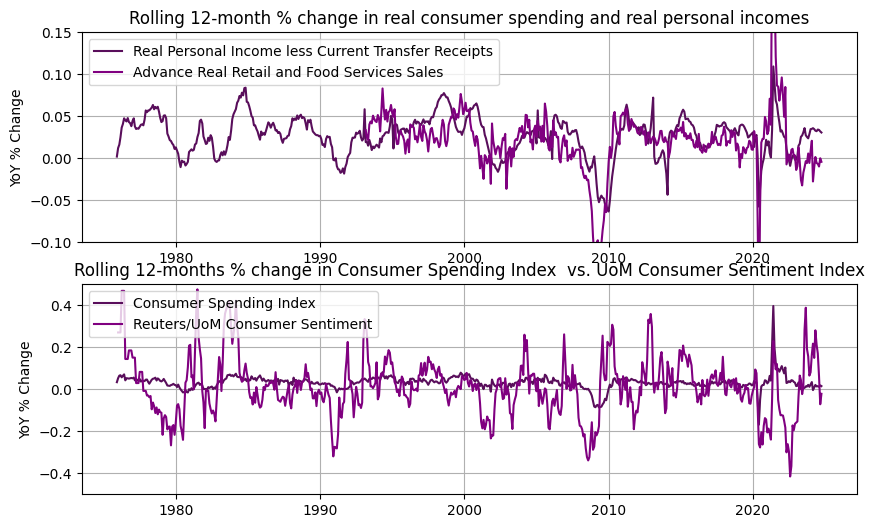

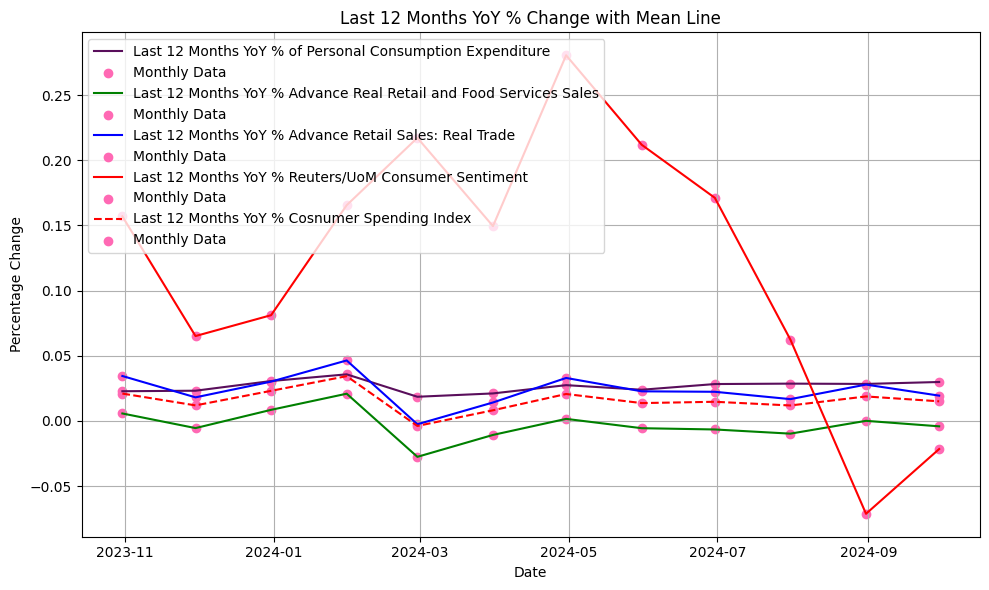

In [492]:
# Consumer Spending
# Lets build the consumer spendig index


consumer_spending = ['PCEC96','RRSFS','UMCSENT', 'W875RX1', 'PCE', 'PCEPI', 'RSXFS']

(consumer_spending_data,
  consumer_spending_data_averages) = download_data(consumer_spending, start_date, end_date)

# shift down due to the way the FRED publishes data
# add an additional row sinceall time series are lagged and need to be adjusted accordingly

new_row_date = consumer_spending_data.index.max() + pd.DateOffset(months=1)
consumer_spending_data.loc[new_row_date] = [np.nan] * consumer_spending_data.shape[1]
consumer_spending_data[['PCEC96','RRSFS','UMCSENT', 'W875RX1', 'PCE', 'PCEPI', 'RSXFS']] =  consumer_spending_data[['PCEC96','RRSFS','UMCSENT', 'W875RX1', 'PCE', 'PCEPI', 'RSXFS']].shift(1)



consumer_spending_data['personal_consumption_expenditure'] = consumer_spending_data['PCE'] / consumer_spending_data['PCEPI']
year_delta_consumer_spending = consumer_spending_data.pct_change(12).shift(1)
year_delta_consumer_spending['consumer_spending_index'] = year_delta_consumer_spending[['personal_consumption_expenditure', 'RSXFS', 'RRSFS']].mean(axis = 1)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_consumer_spending['W875RX1'], color=kkr_purple, label="Real Personal Income less Current Transfer Receipts")
axs[0].plot(year_delta_consumer_spending['RRSFS'], color= 'purple', label="Advance Real Retail and Food Services Sales")
axs[0].set_title("Rolling 12-month % change in real consumer spending and real personal incomes")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
axs[0].set_ylim(-0.1, 0.15)

axs[1].plot(year_delta_consumer_spending['consumer_spending_index'], color=kkr_purple, label="Consumer Spending Index")
axs[1].plot(year_delta_consumer_spending['UMCSENT'], color='purple', label="Reuters/UoM Consumer Sentiment")
axs[1].set_title("Rolling 12-months % change in Consumer Spending Index  vs. UoM Consumer Sentiment Index")
axs[1].set_ylabel("YoY % Change")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)
axs[1].set_ylim(-0.5, 0.5)



fig, axs = plt.subplots(1,1, figsize = (10,6))


# Second subplot: Last 12 months with mean line and markers
axs.plot(year_delta_consumer_spending['personal_consumption_expenditure'].iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % of Personal Consumption Expenditure")
axs.scatter(year_delta_consumer_spending['personal_consumption_expenditure'].iloc[-12:].index, year_delta_consumer_spending['personal_consumption_expenditure'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['RRSFS'].iloc[-12:], color='green', label="Last 12 Months YoY % Advance Real Retail and Food Services Sales")
axs.scatter(year_delta_consumer_spending['RRSFS'].iloc[-12:].index, year_delta_consumer_spending['RRSFS'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['RSXFS'].iloc[-12:], color='blue', label="Last 12 Months YoY % Advance Retail Sales: Real Trade")
axs.scatter(year_delta_consumer_spending['RSXFS'].iloc[-12:].index, year_delta_consumer_spending['RSXFS'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['UMCSENT'].iloc[-12:], color='red', label="Last 12 Months YoY % Reuters/UoM Consumer Sentiment")
axs.scatter(year_delta_consumer_spending['UMCSENT'].iloc[-12:].index, year_delta_consumer_spending['UMCSENT'].iloc[-12:], color=marker_color, label="Monthly Data")

axs.plot(year_delta_consumer_spending['consumer_spending_index'].iloc[-12:], color='red',linestyle = '--', label="Last 12 Months YoY % Cosnumer Spending Index")
axs.scatter(year_delta_consumer_spending['consumer_spending_index'].iloc[-12:].index, year_delta_consumer_spending['consumer_spending_index'].iloc[-12:], color=marker_color, label="Monthly Data")


#axs[0].axhline(labour_market_index.mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs.set_title("Last 12 Months YoY % Change with Mean Line")
axs.set_ylabel("Percentage Change")
axs.set_xlabel("Date")
axs.legend(loc="upper left")
axs.grid(True)

plt.tight_layout()
plt.show

FREQUENCY OF TICKER:
INDPRO : Monthly
FREQUENCY OF TICKER:
CMRMTSPL : Monthly


C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3532456308.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  year_delta_business_activity = business_activity_data.pct_change(12)


<function matplotlib.pyplot.show(close=None, block=None)>

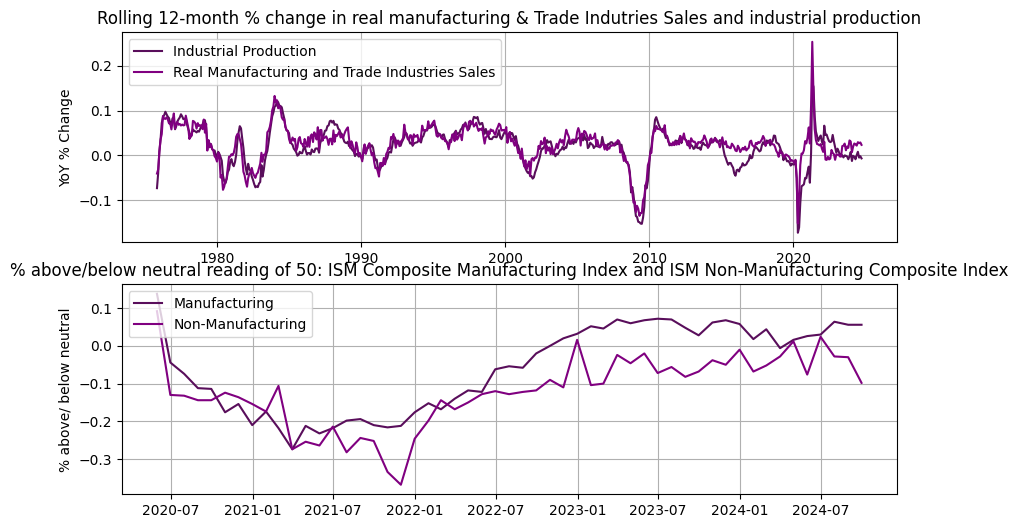

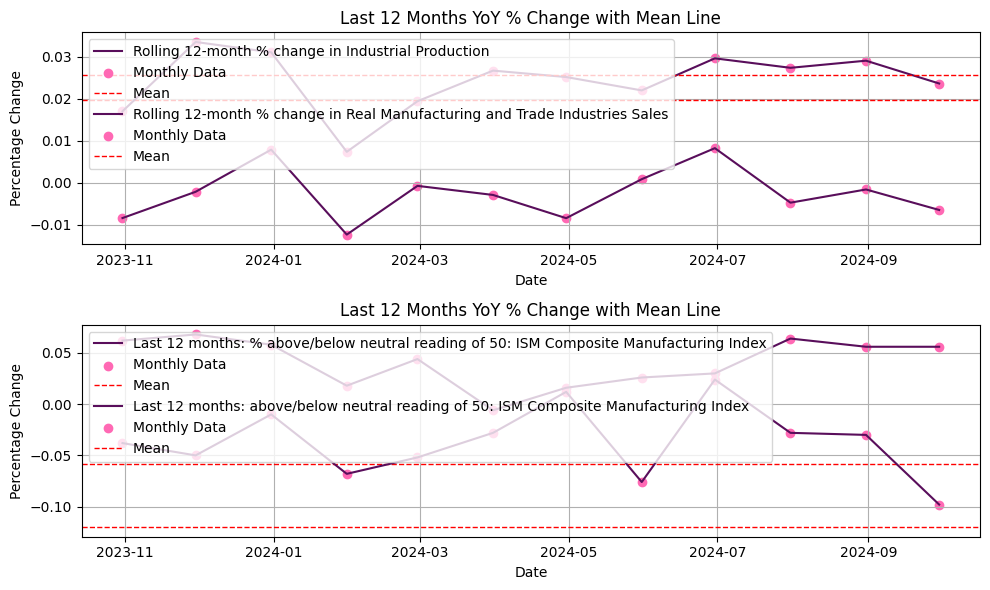

In [493]:
# business spending
business_activity = ['INDPRO', 'CMRMTSPL']

(business_activity_data,
  business_activity_data_averages) = download_data(business_activity, start_date, end_date)

new_row_date = business_activity_data.index.max() + pd.DateOffset(months=1)
business_activity_data.loc[new_row_date] = [np.nan] * business_activity_data.shape[1]
business_activity_data = business_activity_data.shift()

year_delta_business_activity = business_activity_data.pct_change(12)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_business_activity['INDPRO'], color=kkr_purple, label="Industrial Production")
axs[0].plot(year_delta_business_activity['CMRMTSPL'], color= 'purple', label="Real Manufacturing and Trade Industries Sales")
axs[0].set_title("Rolling 12-month % change in real manufacturing & Trade Indutries Sales and industrial production")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
#axs[0].set_ylim(-0.1, 0.15)

# First subplot: Full year-over-year percentage change
axs[1].plot(ISM['Manufacturing delta neutral'], color=kkr_purple, label="Manufacturing")
axs[1].plot(ISM['Non manufacturing delta neutral'], color= 'purple', label="Non-Manufacturing")
axs[1].set_title("% above/below neutral reading of 50: ISM Composite Manufacturing Index and ISM Non-Manufacturing Composite Index")
axs[1].set_ylabel("% above/ below neutral")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)
#axs[1].set_ylim(-0.1, 0.15)



fig, axs = plt.subplots(2,1, figsize = (10,6))

# Second subplot: Last 12 months with mean line and markers
axs[0].plot(year_delta_business_activity['INDPRO'].iloc[-12:], color=kkr_purple, label="Rolling 12-month % change in Industrial Production")
axs[0].scatter(year_delta_business_activity['INDPRO'].iloc[-12:].index, year_delta_business_activity['INDPRO'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[0].axhline(year_delta_business_activity['INDPRO'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")

axs[0].plot(year_delta_business_activity['CMRMTSPL'].iloc[-12:], color=kkr_purple, label="Rolling 12-month % change in Real Manufacturing and Trade Industries Sales")
axs[0].scatter(year_delta_business_activity['CMRMTSPL'].iloc[-12:].index, year_delta_business_activity['CMRMTSPL'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[0].axhline(year_delta_business_activity['CMRMTSPL'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")


axs[0].set_title("Last 12 Months YoY % Change with Mean Line")
axs[0].set_ylabel("Percentage Change")
axs[0].set_xlabel("Date")
axs[0].legend(loc="upper left")
axs[0].grid(True)


axs[1].plot(ISM['Manufacturing delta neutral'].iloc[-12:], color=kkr_purple, label="Last 12 months: % above/below neutral reading of 50: ISM Composite Manufacturing Index")
axs[1].scatter(ISM['Manufacturing delta neutral'].iloc[-12:].index,ISM['Manufacturing delta neutral'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(ISM['Manufacturing delta neutral'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")

axs[1].plot(ISM['Non manufacturing delta neutral'].iloc[-12:], color=kkr_purple, label="Last 12 months: above/below neutral reading of 50: ISM Composite Manufacturing Index")
axs[1].scatter(ISM['Non manufacturing delta neutral'].iloc[-12:].index,ISM['Non manufacturing delta neutral'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(ISM['Non manufacturing delta neutral'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")

axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)


plt.tight_layout()
plt.show

FREQUENCY OF TICKER:
DCOILWTICO : Daily


c:\Users\jerem\Documents\GitHub\Nowcasting-the-Business-Cycle\Data_Sourcing_v1.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_dict[tick] = data_dict[tick].resample('M').mean()


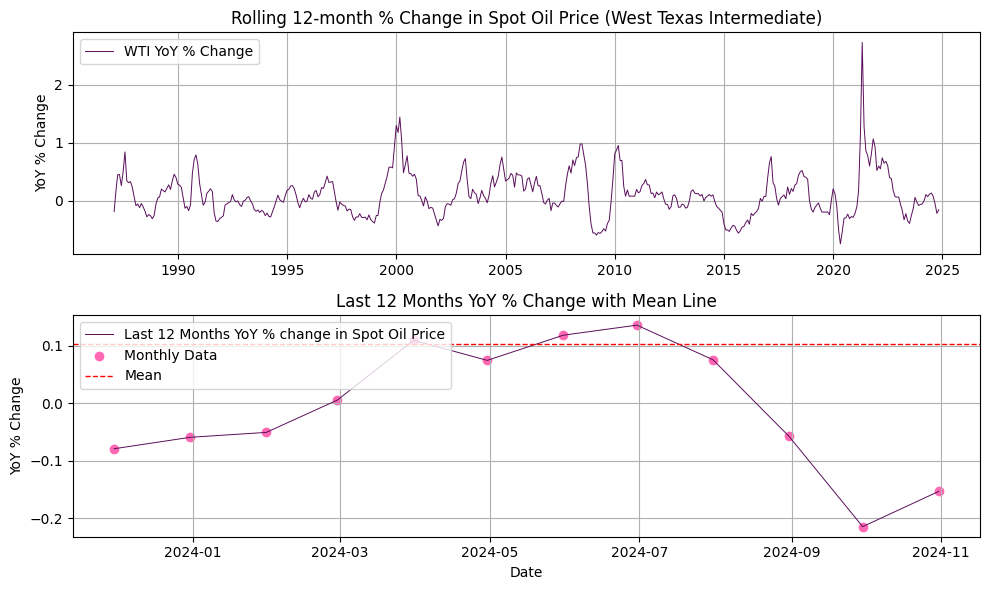

In [494]:
#oil

oil = ['DCOILWTICO']

(oil_data,
  oil_data_averages) = download_data(oil, start_date, end_date)

year_delta_oil = oil_data_averages.pct_change(12)

graph(year_delta_oil['DCOILWTICO'],
      "Rolling 12-month % Change in Spot Oil Price (West Texas Intermediate)",
      "WTI YoY % Change",
      "YoY % Change",
      "Last 12 Months YoY % Change with Mean Line",
      "Last 12 Months YoY % change in Spot Oil Price",
      "YoY % Change",
      )

FREQUENCY OF TICKER:
BOGMBASE : Monthly
FREQUENCY OF TICKER:
CPIAUCSL : Monthly


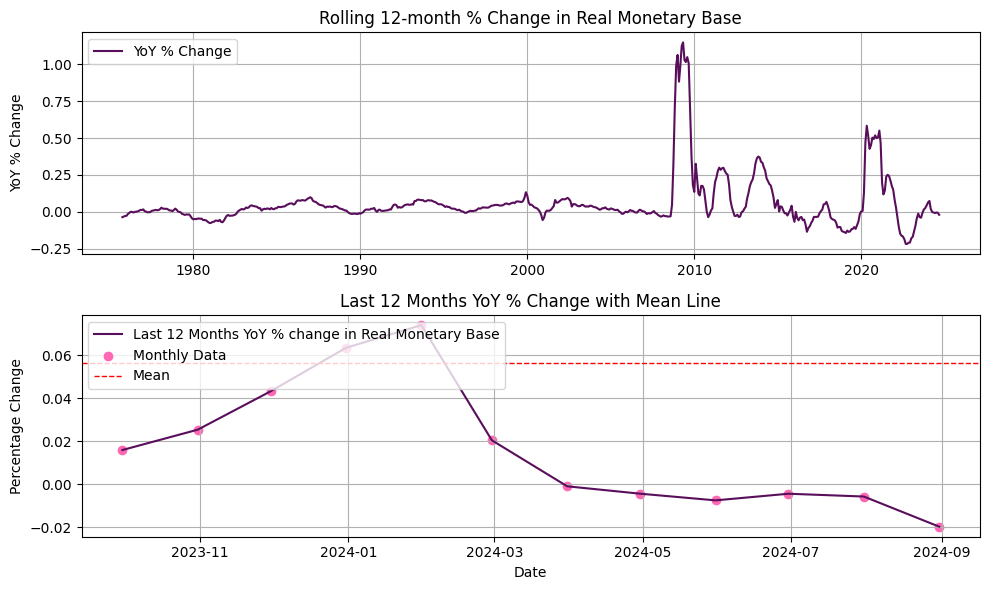

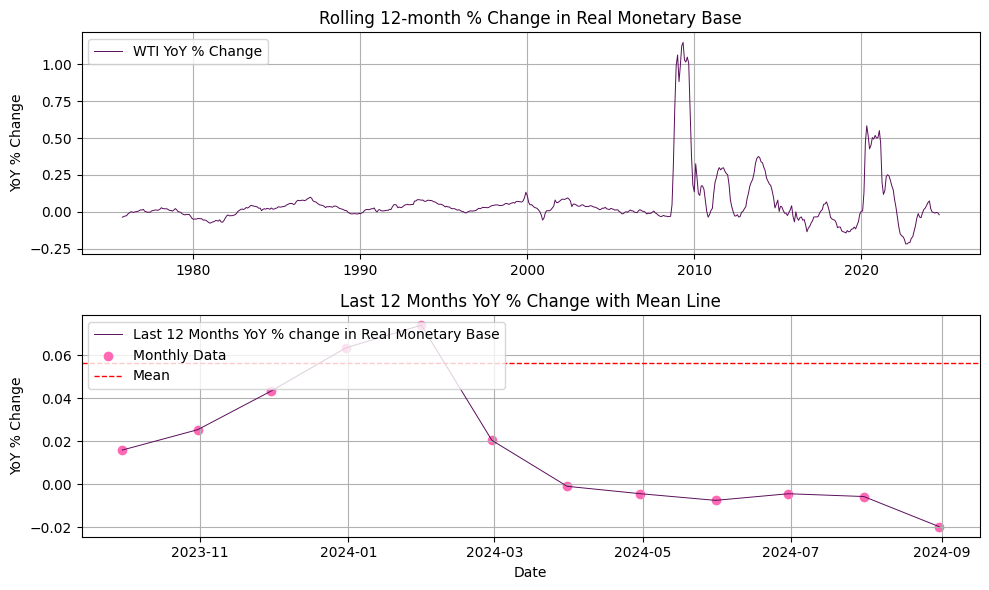

In [495]:
# Money Supply


monetary_base = ['BOGMBASE','CPIAUCSL']


(monetary_base_data,
  monetary_base_data_averages) = download_data(monetary_base, start_date, end_date)

monetary_base_data_averages['real monetary base'] = monetary_base_data_averages['BOGMBASE'] / monetary_base_data_averages['CPIAUCSL']
year_delta_monetary_base = monetary_base_data_averages.pct_change(12)


fig, axs = plt.subplots(2,1, figsize = (10,6))

# First subplot: Full year-over-year percentage change
axs[0].plot(year_delta_monetary_base['real monetary base'], color=kkr_purple, label="YoY % Change")
axs[0].set_title("Rolling 12-month % Change in Real Monetary Base")
axs[0].set_ylabel("YoY % Change")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)
# Second subplot: Last 12 months with mean line and markers
axs[1].plot(year_delta_monetary_base['real monetary base'].iloc[-12:], color=kkr_purple, label="Last 12 Months YoY % change in Real Monetary Base")
axs[1].scatter(year_delta_monetary_base['real monetary base'].iloc[-12:].index, year_delta_monetary_base['real monetary base'].iloc[-12:], color=marker_color, label="Monthly Data")
axs[1].axhline(year_delta_monetary_base['real monetary base'].mean(), color='red', linestyle='--', linewidth=1, label="Mean")
axs[1].set_title("Last 12 Months YoY % Change with Mean Line")
axs[1].set_ylabel("Percentage Change")
axs[1].set_xlabel("Date")
axs[1].legend(loc="upper left")
axs[1].grid(True)

plt.tight_layout()
plt.show

graph(year_delta_monetary_base['real monetary base'],
      "Rolling 12-month % Change in Real Monetary Base",
      "WTI YoY % Change",
      "YoY % Change",
      "Last 12 Months YoY % Change with Mean Line",
      "Last 12 Months YoY % change in Real Monetary Base",
      "YoY % Change",
      )

FREQUENCY OF TICKER:
PERMIT : Monthly


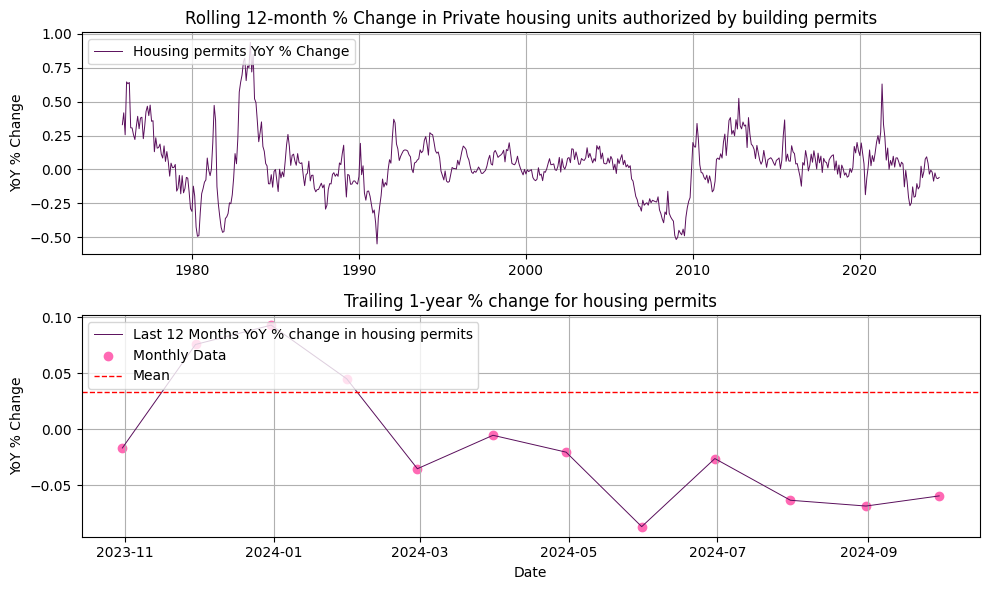

In [496]:
# housing market
housing = ['PERMIT']

(housing_data,
  housing_data_averages) = download_data(housing, start_date, end_date)

new_row_date = housing_data_averages.index.max() + pd.DateOffset(months=1)
housing_data_averages.loc[new_row_date] = [np.nan] * housing_data_averages.shape[1]
housing_data_averages = housing_data_averages.shift()

year_delta_housing = housing_data_averages.pct_change(12)


graph(year_delta_housing['PERMIT'],
      "Rolling 12-month % Change in Private housing units authorized by building permits",
      "Housing permits YoY % Change",
      "YoY % Change",
      "Trailing 1-year % change for housing permits",
      "Last 12 Months YoY % change in housing permits",
      "YoY % Change",
      )

In [497]:
# Combine all time series that were going to be using for the 

indicators = pd.concat([year_delta_stock_market, # Stock market YoY change , 421
                        yield_curve_data_averages['T10Y3M'][1:]/10, # Yield curve % spread (multiplied by 10), 422
                        year_delta_credit_spread, # Credit Spread YoY change
                        labour_market_index, # Labour Market Index
                        year_delta_consumer_spending['consumer_spending_index'], # Personal COnsumption Expenditure, Advanced retail sales: real trade, dvance Real Retail and Food Services Sales
                        year_delta_consumer_spending['UMCSENT'], # Reuters, UoM  Consumer Sentiment 
                        year_delta_business_activity['INDPRO'],# Industrial production
                        year_delta_business_activity['CMRMTSPL'], # Real Manufacturing and Trade Industries Sales
                        ISM['Manufacturing delta neutral'], # ISM Manufacturing
                        ISM['Non manufacturing delta neutral'], # ISM non-manufacturing
                        year_delta_oil['DCOILWTICO'], # Crude Oil
                        year_delta_housing['PERMIT'], # housing starts
                        ], axis = 1)

Optimization terminated successfully.
         Current function value: 0.029472
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.122651
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034726
         Iterations 13
                          Probit Regression Results                           
Dep. Variable:              recession   No. Observations:                  587
Model:                         Probit   Df Residuals:                      585
Method:                           MLE   Df Model:                            1
Date:                Thu, 31 Oct 2024   Pseudo R-squ.:                  0.9376
Time:                        19:08:48   Log-Likelihood:                -17.300
converged:                       True   LL-Null:                       -277.22
Covariance Type:            nonrobust   LLR p-value:                4.571e-115
                 coef    std err          z      P>|z|      

C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\301872994.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].scatter(EMI.index[-1], EMI[-1], color =  'red', label = "Latest EMI reading", marker = 'D')
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\301872994.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[1].scatter(ETI.index[-1], ETI[-1], color =  'red', label = "Latest ETI reading", marker = 'D')
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\301872994.py:62: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

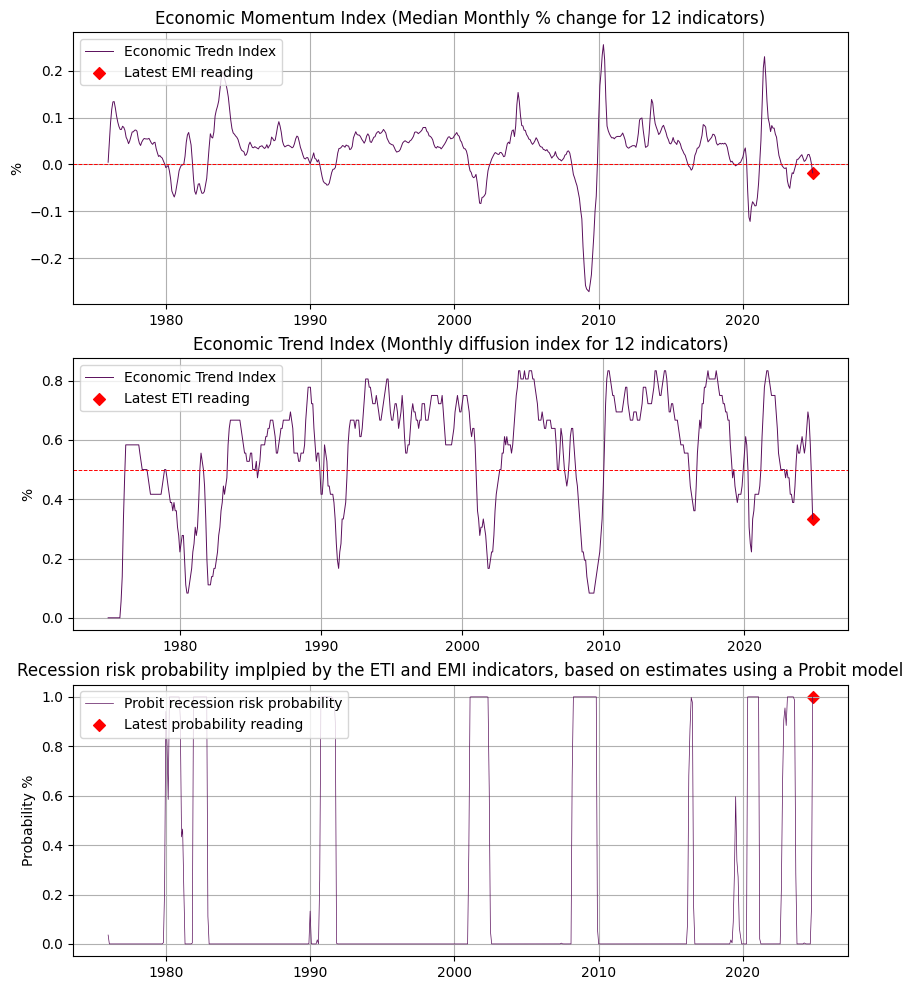

In [498]:
EMI_base = indicators.median(axis = 1)
EMI_base.name = 'EMI'
EMI = EMI_base.rolling(3).mean()

rising_indicators = indicators> 0
ETI_base = rising_indicators.mean(axis = 1)
ETI_base.name = 'ETI'
ETI = ETI_base.rolling(3).mean()


probit_data = pd.concat([EMI, ETI], axis = 1).dropna()
probit_data['recession'] = ((ETI < 0.50) & (EMI<0)).astype(int) # returns 1 if recesssion, returns 0 otherwise


# fit the probit model
X = probit_data['ETI']
X_2 = probit_data['EMI']
X_3 = probit_data[['ETI', 'EMI']]
X = sm.add_constant(X)
y = probit_data['recession']


probit_model_1 = sm.Probit(y, X)
probit_model_2 = sm.Probit(y, X_2)
probit_model_3 = sm.Probit(y, X_3)
probit_results = probit_model_3.fit()

# Alt formulations of the probit models
probit_results_1 = probit_model_1.fit()
probit_results_2 = probit_model_2.fit()


print(probit_results.summary())


probit_data['recession_probability'] = probit_results.predict(X_3)

probit_data['recession_probability_alt_1'] = probit_results_1.predict(X)
probit_data['recession_probability_alt_2'] = probit_results_2.predict(X_2)

fig, axs = plt.subplots(3,1, figsize = (10,12))

# First subplot: Full year-over-year percentage change
axs[0].plot(EMI, color=kkr_purple, label="Economic Tredn Index", linewidth = 0.7)
axs[0].axhline(0.0, color = 'red', linestyle = '--', linewidth = 0.7)   
axs[0].scatter(EMI.index[-1], EMI[-1], color =  'red', label = "Latest EMI reading", marker = 'D')
axs[0].set_title("Economic Momentum Index (Median Monthly % change for 12 indicators)")
axs[0].set_ylabel("%")
axs[0].legend(loc="upper left")  # Add legend here with label
axs[0].grid(True)

axs[1].plot(ETI, color=kkr_purple, label="Economic Trend Index", linewidth = 0.7)
axs[1].axhline(0.5, color = 'red', linestyle = '--', linewidth = 0.7)
axs[1].scatter(ETI.index[-1], ETI[-1], color =  'red', label = "Latest ETI reading", marker = 'D')
axs[1].set_title("Economic Trend Index (Monthly diffusion index for 12 indicators)")
axs[1].set_ylabel("%")
axs[1].legend(loc="upper left")  # Add legend here with label
axs[1].grid(True)

axs[2].plot(probit_data['recession_probability'], color=kkr_purple, label="Probit recession risk probability", linewidth = 0.5)
axs[2].set_title("Recession risk probability implpied by the ETI and EMI indicators, based on estimates using a Probit model")
axs[2].scatter(probit_data['recession_probability'].index[-1], probit_data['recession_probability'][-1], color =  'red', label = "Latest probability reading", marker = 'D')
axs[2].set_ylabel("Probability %")
axs[2].legend(loc="upper left")  # Add legend here with label
axs[2].grid(True)

plt.show()


C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3703784202.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].scatter(EMI.index[-1], EMI[-1], color =  'red', label = "Latest EMI reading", marker = 'D')
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3703784202.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[1].scatter(ETI.index[-1], ETI[-1], color =  'red', label = "Latest ETI reading", marker = 'D')
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3703784202.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treat

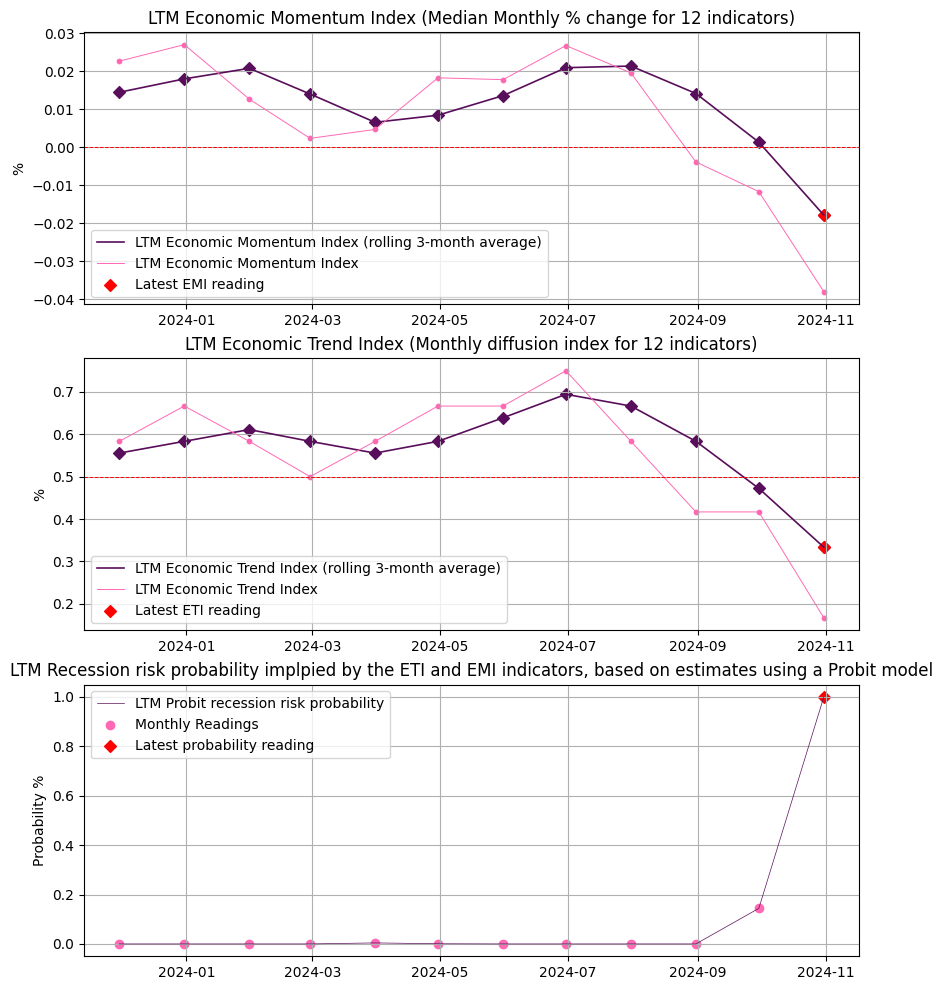

In [499]:
# Show Last Twlve Months evolution of the time series

fig, axs = plt.subplots(3,1, figsize = (10,12))

axs[0].plot(EMI.iloc[-12:], color=kkr_purple, label="LTM Economic Momentum Index (rolling 3-month average)", linewidth = 1.2)
axs[0].plot(EMI_base.iloc[-12:], color='#FF69B4', label="LTM Economic Momentum Index", linewidth = 0.7)
axs[0].axhline(0.0, color = 'red', linestyle = '--', linewidth = 0.7)
axs[0].scatter(EMI.iloc[-12:].index, EMI.iloc[-12:], color='#590e5b', marker = 'D')
axs[0].scatter(EMI_base.iloc[-12:].index, EMI_base.iloc[-12:], color='#FF69B4', marker = 'o', s = 10)
axs[0].scatter(EMI.index[-1], EMI[-1], color =  'red', label = "Latest EMI reading", marker = 'D')
axs[0].set_title("LTM Economic Momentum Index (Median Monthly % change for 12 indicators)")
axs[0].set_ylabel("%")
axs[0].legend(loc="lower left")  # Add legend here with label
axs[0].grid(True)

axs[1].plot(ETI.iloc[-12:], color=kkr_purple, label="LTM Economic Trend Index (rolling 3-month average)", linewidth = 1.2)
axs[1].plot(ETI_base.iloc[-12:], color='#FF69B4', label="LTM Economic Trend Index", linewidth = 0.7)
axs[1].axhline(0.5, color = 'red', linestyle = '--', linewidth = 0.7)
axs[1].scatter(ETI.iloc[-12:].index, ETI.iloc[-12:], color='#590e5b', marker = 'D')
axs[1].scatter(ETI_base.iloc[-12:].index, ETI_base.iloc[-12:], color='#FF69B4', marker = 'o', s = 10)
axs[1].scatter(ETI.index[-1], ETI[-1], color =  'red', label = "Latest ETI reading", marker = 'D')
axs[1].set_title("LTM Economic Trend Index (Monthly diffusion index for 12 indicators)")
axs[1].set_ylabel("%")
axs[1].legend(loc="lower left")  # Add legend here with label
axs[1].grid(True)

axs[2].plot(probit_data['recession_probability'].iloc[-12:], color=kkr_purple, label="LTM Probit recession risk probability", linewidth = 0.5)
#axs[2].plot(probit_data['recession_probability_alt_1'].iloc[-12:], color=kkr_purple, label="LTM Probit recession risk probability (ETI only)", linewidth = 0.5)
#axs[2].plot(probit_data['recession_probability_alt_2'].iloc[-12:], color=kkr_purple, label="LTM Probit recession risk probability(EMI only)", linewidth = 0.5)
axs[2].set_title("LTM Recession risk probability implpied by the ETI and EMI indicators, based on estimates using a Probit model")
axs[2].scatter(probit_data['recession_probability'].iloc[-12:].index, probit_data['recession_probability'].iloc[-12:], color='#FF69B4', label="Monthly Readings")
axs[2].scatter(probit_data['recession_probability'].index[-1], probit_data['recession_probability'][-1], color =  'red', label = "Latest probability reading", marker = 'D')
axs[2].set_ylabel("Probability %")
axs[2].legend(loc="upper left")  # Add legend here with label
axs[2].grid(True)

plt.show()


In [500]:
# print out the latest ETI, EMI and probit readings:

print('------------------------------')

print(f"LATEST ETI READING: {ETI[-1]}")
print('------------------------------')

print(f"LATEST EMI READING: {EMI[-1]}")
print('------------------------------')

print(f"LATEST RECESION RISK PROBABILITY READING: {probit_data['recession_probability'][-1]}")
print('------------------------------')

------------------------------
LATEST ETI READING: 0.3333333333333335
------------------------------
LATEST EMI READING: -0.017882332408059993
------------------------------
LATEST RECESION RISK PROBABILITY READING: 0.9999961720539668
------------------------------


C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\2737321813.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"LATEST ETI READING: {ETI[-1]}")
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\2737321813.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"LATEST EMI READING: {EMI[-1]}")
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\2737321813.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"LATEST R

C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3576304650.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[0].axvline(EMI[-1], color = 'red', linestyle = '--')
C:\Users\jerem\AppData\Local\Temp\ipykernel_45684\3576304650.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axs[1].axvline(ETI[-1], color = 'red', linestyle = '--')


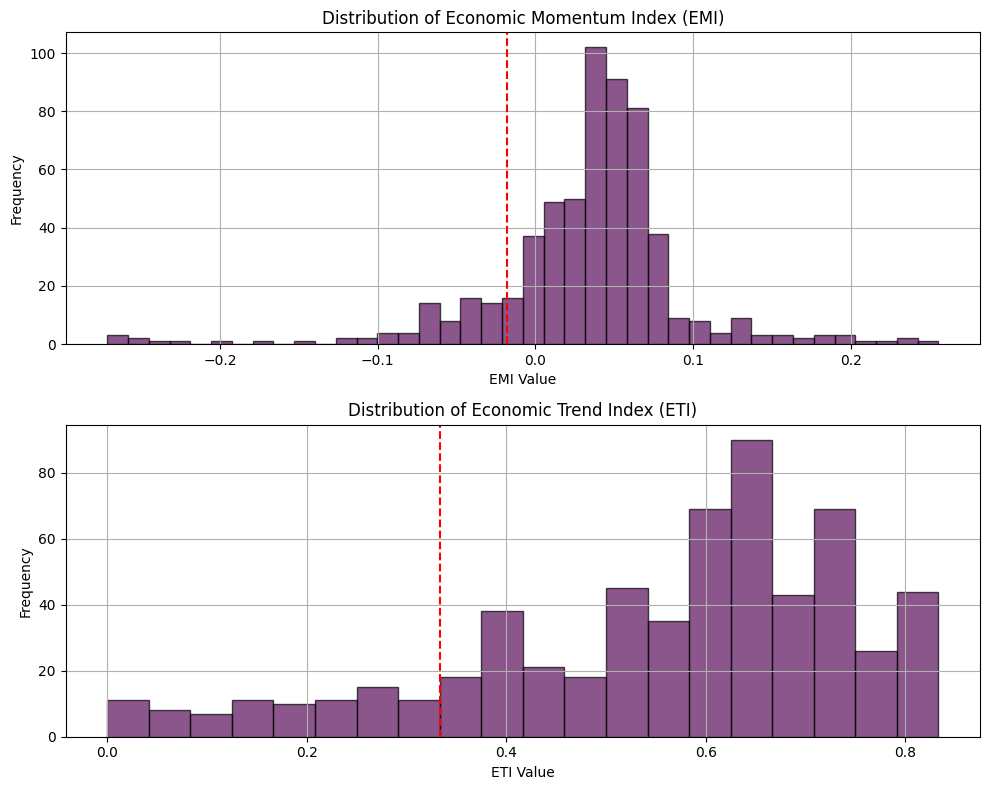

In [501]:

# Set up the figure and axes for two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Histogram for EMI
axs[0].hist(EMI, bins=40, color='#590e5b', edgecolor='black', alpha=0.7)
axs[0].axvline(EMI[-1], color = 'red', linestyle = '--')
axs[0].set_title("Distribution of Economic Momentum Index (EMI)")
axs[0].set_xlabel("EMI Value")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)

# Histogram for ETI
axs[1].hist(ETI, bins=20, color='#590e5b', edgecolor='black', alpha=0.7)
axs[1].set_title("Distribution of Economic Trend Index (ETI)")
axs[1].axvline(ETI[-1], color = 'red', linestyle = '--')
axs[1].set_xlabel("ETI Value")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

plt.tight_layout()
plt.show()


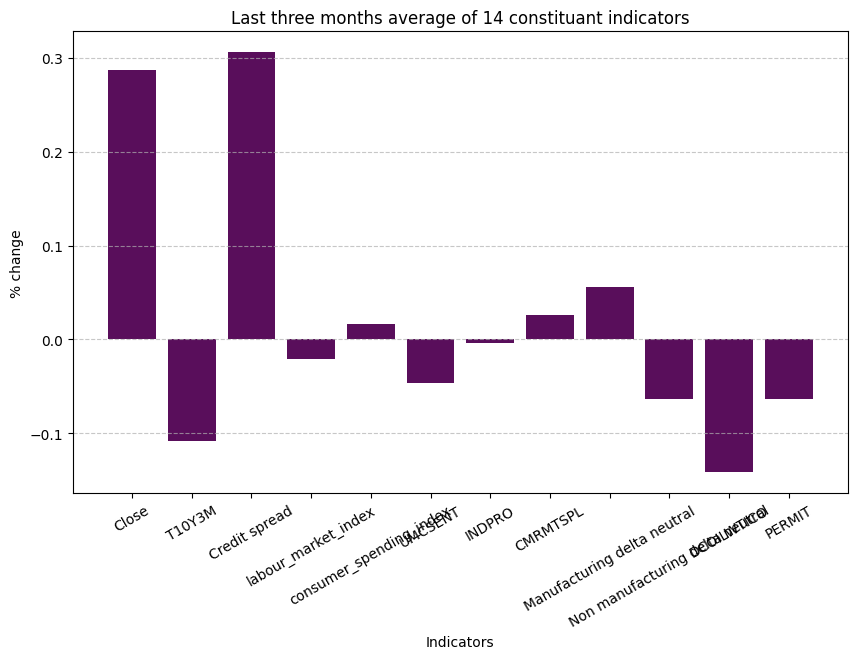

In [ ]:
# Lets fid out where the main negatives came from

indicators_L3M = indicators.iloc[-3:, :].mean()

# Create the figure and bar chart
plt.figure(figsize=(16, 6))
bars = plt.bar(indicators_L3M.index, indicators_L3M, color='#590e5b')

# Formatting the chart
plt.xticks(rotation=30)  # Rotate category names by 90 degrees
plt.xlabel("Indicators")
plt.ylabel("% change")
plt.title("Last three months average of 14 constituant indicators")
plt.grid(axis='y', linestyle='--', alpha=0.7)